<a href="https://colab.research.google.com/github/romanbash/DTSA-5509---final-project/blob/main/stroke_prediction_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic

In the project, we will try to predict **strokes** by using data that can be easily measured and obtained from the sample participants.
The problem (the **goal** of this exercise) we will try to solve is *predicting in advance which patients have a greater chance of having a stroke*. We aim to reduce this chance in advance through a healthier life span, preventive treatment, and closer follow-up.
We will do this by analyzing stroke information—that is, we will solve the problem using **supervised learning**. In the research process, we will use Different algorithms are linear regression, isolation forest (unsupervised), random forest, and SVM.
The task is of *binary classification* type - stroke or not stroke.

In [1]:
#First we install and import the packages will will use in our project.
!pip install pandas scikit-learn imbalanced-learn
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

In [2]:
# We mount our google drive, where we store our data

from google.colab import drive
drive.mount('/content/drive')


#This is the path for the data in the goggle drive. If you would like to run it
#change this line to the path in your drive.

data_path = '/content/drive/MyDrive/DTSA 5509 - final project/healthcare-dataset-stroke-data.csv'

Mounted at /content/drive


# Data

###Context - taken for Kaggle
According to the World Health Organization (WHO), stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get a stroke based on input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relevant information about the patient.

### Number of features/columns: 5110 rows and 12 columns.

### Size: 310 Kb



###Attribute Information
1) **id**: unique identifier

2) **gender**: "Male", "Female" or "Other"

3) **age**: age of the patient

4) **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) **ever_married**: "No" or "Yes"

7) **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) **Residence_type**: "Rural" or "Urban"

9) **avg_glucose_level**: average glucose level in blood

10) **bmi**: body mass index

11) **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) **stroke**: 1 if the patient had a stroke or 0 if not

*Note*: "Unknown" in smoking_status means that the information is unavailable for this patient


**Kaggle URL**: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

**Download data**: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/download?datasetVersionNumber=1



In [24]:
# read csv to data frame
df = pd.read_csv(data_path)


In [4]:
# Show the head of the df, to see that looks good
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# See if the shape fits the csv.
df.shape

(5110, 12)

The columns of our data are:

In [6]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

So we have 5100 entries and 12 columns - 11 optional features and the label column - *stroke*.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


# Data Cleaning

The only column that is not relevant for now is the ID column. It can not be a valuable feature because it is just a random number that does not contain any information. We should remove it.

In [8]:
# drop id column
df.drop('id', axis=1, inplace=True)

Let's check if we have duplicate rows.

In [9]:
#check for duplicates
df.duplicated().sum()

0

We don't have duplicates. let's see if we have missing data.

In [10]:
#check for missing data
missing_data = df.isnull().sum()
# Print the number of missing values in each column
print(missing_data)


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


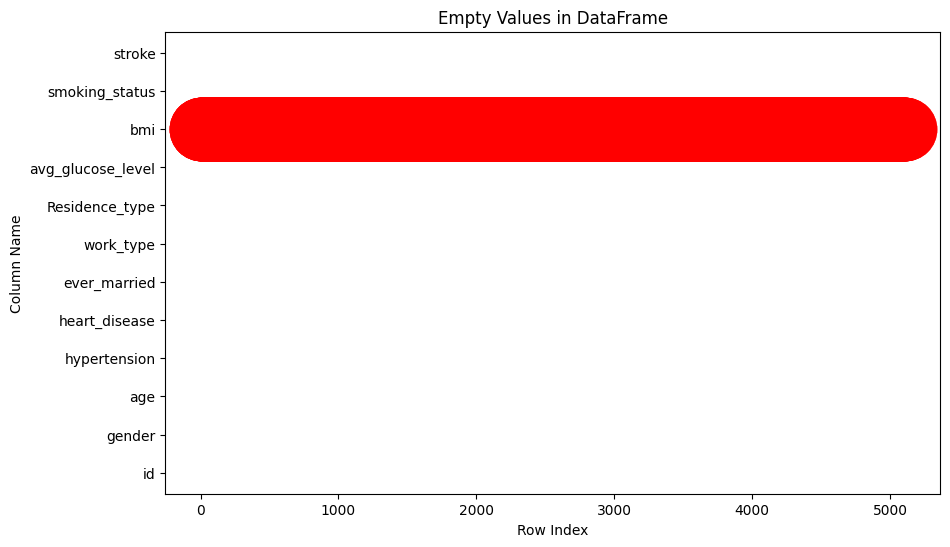

In [25]:
# Create a scatter plot with varying marker point size and color
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
for col in df.columns:
    empty_cells = df[col].isnull().sum()
    plt.scatter(df.index, [col] * len(df), s=empty_cells * 10, c='red', alpha=0.5)

# Customize the plot (add labels, title, etc.)
plt.xlabel("Row Index")
plt.ylabel("Column Name")
plt.title("Empty Values in DataFrame")

# Show the plot
plt.show()

We see 201 rows with missing data in the BMI column. This is the only column with missing data. We need to handle this.

In order to choose the best way to impute missing data, we want to see the distribution of the data; we can attribute the missing values with mean, median, or mode. We will try to impute with a regration or k-nearest neighbors models. First, let's see the data distribution:

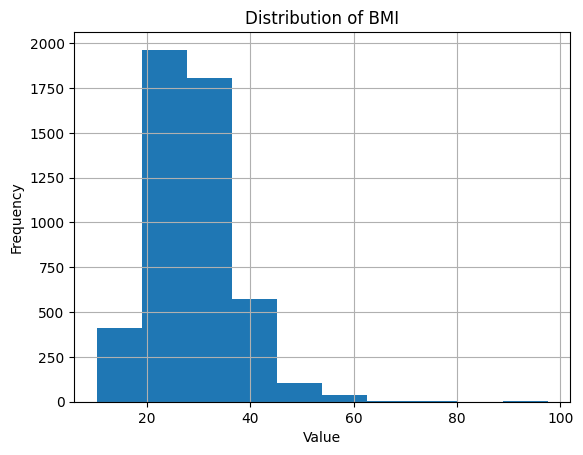

In [11]:
df['bmi'].hist()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of BMI')
plt.show()

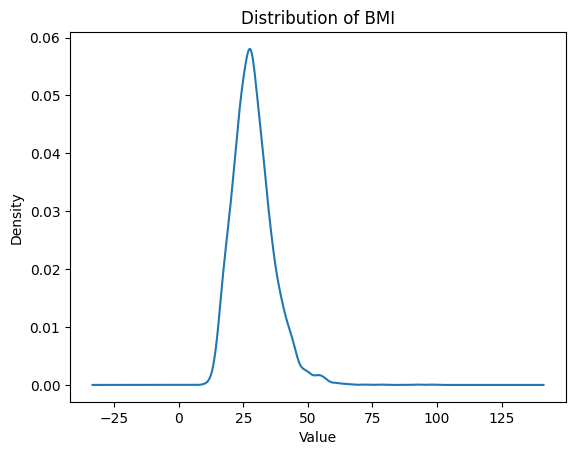

In [12]:
df['bmi'].plot.kde()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of BMI')
plt.show()

The distribution looks **normal**, we will perform the *Shapiro-Wilk test*.
The Shapiro–Wilk test is a test of normality.
The null-hypothesis of this test is that the population is normally distributed. Thus, if the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis (that the data came from a normally distributed population) can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population – consequently, a data set with a p value more than the .05 alpha value fails to reject the null hypothesis that the data is from a normally distributed population).

In [13]:
# Perform a Shapiro-Wilk test
stat, p = shapiro(df['bmi'])
print('Shapiro-Wilk test results: statistic = %.3f, p-value = %.3f' % (stat, p))

# Interpret the results
if p > 0.05:
    print('The data is likely normally distributed.')
else:
    print('The data is not likely normally distributed.')

Shapiro-Wilk test results: statistic = nan, p-value = 1.000
The data is likely normally distributed.


So, the data is normally distributed. Let's handle the categorical columns and use **linear regression** to impute the missing points.

The variable with missing data is used as the *dependent variable* (BMI). Cases with complete data for the predictor variables are used to generate the regression equation (in our case - all the other variables) the equation is then used to predict missing values for incomplete cases. In an iterative process, values for the missing variable are inserted and then all cases are used to predict the dependent variable.

In [14]:
# Select categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Print the categorical columns
print(categorical_cols)


unique_values = {}
for col in categorical_cols:
    unique_values[col] = df[col].nunique()

# Print the number of unique values
print(unique_values)

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')
{'gender': 3, 'ever_married': 2, 'work_type': 5, 'Residence_type': 2, 'smoking_status': 4}


First, we need to handle the *categorical columns*.
These columns don't have a natural ordering, and the number of unique values is small so that we will use one hot encoding.

In [15]:
#binary columns:

df_encoded = pd.get_dummies(df, columns=['ever_married', 'Residence_type'], drop_first=True)

#molti values columns:
df_encoded = pd.get_dummies(df_encoded, columns=['work_type','smoking_status','gender', ])



df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             4909 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   ever_married_Yes                5110 non-null   bool   
 7   Residence_type_Urban            5110 non-null   bool   
 8   work_type_Govt_job              5110 non-null   bool   
 9   work_type_Never_worked          5110 non-null   bool   
 10  work_type_Private               5110 non-null   bool   
 11  work_type_Self-employed         5110 non-null   bool   
 12  work_type_children              51

We use the linear regression model to impute the missing data points.

In [16]:
# Choose a regression model
model = LinearRegression()

# we drop the dependent variable and the variable we want to impute
df_dropped = df_encoded.dropna(axis=0)
X = df_dropped.drop(['bmi','stroke'], axis=1)
y = df_dropped['bmi']

# Train the model
model.fit(X, y)



LinearRegression()

Now we can use our model to impute the missing values of the BMI.

In [17]:
# Predict the missing values

df_encoded_with_na = df_encoded[df_encoded['bmi'].isnull()]

df_encoded_with_na['bmi'] = model.predict(df_encoded_with_na.drop(['bmi','stroke'], axis=1))

df = pd.concat([df_dropped, df_encoded_with_na], ignore_index=True)


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   int64  
 2   heart_disease                   5110 non-null   int64  
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   ever_married_Yes                5110 non-null   bool   
 7   Residence_type_Urban            5110 non-null   bool   
 8   work_type_Govt_job              5110 non-null   bool   
 9   work_type_Never_worked          5110 non-null   bool   
 10  work_type_Private               5110 non-null   bool   
 11  work_type_Self-employed         5110 non-null   bool   
 12  work_type_children              51

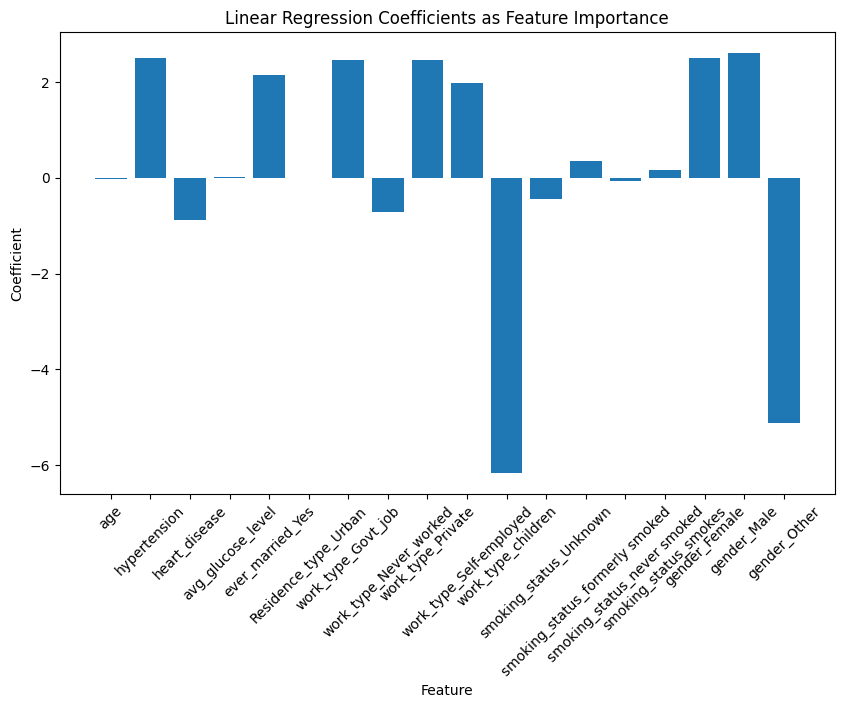

In [20]:
# Get the coefficients from the trained model
coefficients = model.coef_

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(X.columns, coefficients)
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("Linear Regression Coefficients as Feature Importance")
plt.xticks(rotation=45)
plt.show()

We see by plotting the feature importance results in that it makes sense and can show the model gives valid results - features like gender are important features in calculating the BMI; on the other hand, self-employed work type has little value in this calculation.

###conculution
In this data-cleaning section, we:
1. remove the ID column because it is irrelevant to our problem.
2. made use of linear regression to impute the missing BMI values. After The Shapiro–Wilk test, we used this model and found that the IBM distribution is normal. The mean or median input technique won't give us a good result in normal distribution. In linear regression, by design, we choose other variables that affect the BMI and use them to impute better values.
3. important notice: we didn't use the stoke variable to prevent data leakage.

# Exploratory Data Analysis

In [ ]:
# plot the corolation between columns

df.corr().style.background_gradient(cmap='coolwarm')


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,ever_married_Yes,Residence_type_Urban,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,gender_Other
age,1.000000,0.276398,0.263796,0.238171,0.336922,0.245257,0.679125,0.014180,0.130013,-0.078653,0.116534,0.327989,-0.634215,-0.378231,0.236897,0.119307,0.073133,0.027924,-0.027623,-0.010659
hypertension,0.276398,1.000000,0.108306,0.174474,0.173416,0.127904,0.164243,-0.007913,0.017685,-0.021608,-0.005413,0.115442,-0.129506,-0.141501,0.058853,0.065063,0.031240,-0.021143,0.021275,-0.004597
heart_disease,0.263796,0.108306,1.000000,0.161857,0.042485,0.134914,0.114644,0.003092,0.001330,-0.015712,0.000027,0.086760,-0.091634,-0.066731,0.066804,-0.021856,0.044049,-0.085617,0.085717,-0.003343
avg_glucose_level,0.238171,0.174474,0.161857,1.000000,0.180418,0.131945,0.155068,-0.004946,0.013845,-0.014675,0.016588,0.062694,-0.102250,-0.095131,0.068111,0.023885,0.017646,-0.054902,0.054580,0.011489
bmi,0.336922,0.173416,0.042485,0.180418,1.000000,0.043330,0.345786,-0.000864,0.079109,-0.028897,0.208924,0.072937,-0.453515,-0.271020,0.107069,0.105675,0.091067,0.024540,-0.024206,-0.011841
stroke,0.245257,0.127904,0.134914,0.131945,0.043330,1.000000,0.108340,0.015458,0.002677,-0.014882,0.011888,0.062168,-0.083869,-0.055892,0.064556,-0.004129,0.008939,-0.009027,0.009117,-0.003166
ever_married_Yes,0.679125,0.164243,0.114644,0.155068,0.345786,0.108340,1.000000,0.006261,0.134041,-0.090838,0.153830,0.192716,-0.544441,-0.332081,0.171256,0.102845,0.105226,0.030483,-0.029936,-0.019327
Residence_type_Urban,0.014180,-0.007913,0.003092,-0.004946,-0.000864,0.015458,0.006261,1.000000,0.013131,0.022859,-0.018173,0.010594,-0.002309,-0.002036,0.007654,-0.024466,0.027266,0.006340,-0.005937,-0.014217
work_type_Govt_job,0.130013,0.017685,0.001330,0.013845,0.079109,0.002677,0.134041,0.013131,1.000000,-0.025258,-0.444420,-0.167810,-0.151383,-0.097418,0.029686,0.046908,0.030026,0.016685,-0.016534,-0.005374
work_type_Never_worked,-0.078653,-0.021608,-0.015712,-0.014675,-0.028897,-0.014882,-0.090838,0.022859,-0.025258,1.000000,-0.076081,-0.028728,-0.025915,0.008804,-0.030095,0.036238,-0.028099,-0.011469,0.011496,-0.000920


**We can not see a feature that is highly correlated to stroke.**
Highly correlated is considered correlation more significant than 0.7.
We do not see features that have a close correlation to this. This will also affect the choice of our model—it can be seen from the matrix that we would like to look for non-linear relationships between variables that will give us a good result. There are no significant linear. Relationships in our data.
We would also like to find a significant correlation between the variables themselves. The only variables with a significant correlation are age and children. This makes sense because the older the person gets, the more likely they are to have children. However, this is not significant in itself for stroke detection.

Let's plot the stroke numbers to see if the dataset is balanced.

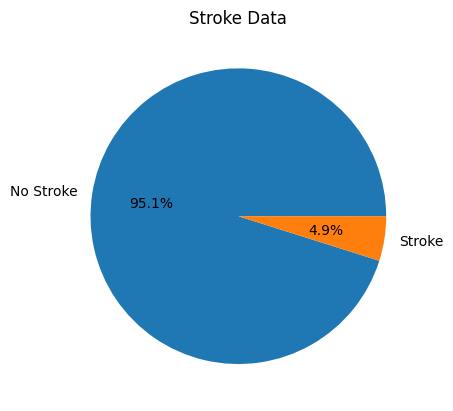

In [ ]:
stroke_counts = df['stroke'].value_counts()
stroke_percentages = stroke_counts / len(df) * 100


plt.pie(stroke_percentages, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%')
plt.title('Stroke Data')
plt.show()

The data set is highly unbalanced.



In [ ]:
data = pd.read_csv(data_path)
data.drop(['id', 'stroke'], axis=1, inplace=True)

# Calculate the number of unique values in each column
categorical_cols = ['ever_married', 'Residence_type', 'work_type','smoking_status','gender']
# Calculate the number of unique values in each categorical column
unique_values = data[categorical_cols].nunique()

# Calculate the total number of rows in the dataframe
total_rows = len(data)

# Check if each categorical column is balanced
for column in categorical_cols:
    if unique_values[column] <= total_rows ** 0.5:
        print(f"Column '{column}' is balanced.")
    else:
        print(f"Column '{column}' is not balanced.")



Column 'ever_married' is balanced.
Column 'Residence_type' is balanced.
Column 'work_type' is balanced.
Column 'smoking_status' is balanced.
Column 'gender' is balanced.


All the other categorical columns are balanced. That is great.
Let's plot the distribution, calculate the statistical data, and see if we can find something valuable.

Column: age
Mean: 43.226614481409
Standard deviation: 22.61264672311349
Skewness: -0.1370593225984694
Kurtosis: -0.9910102432016696


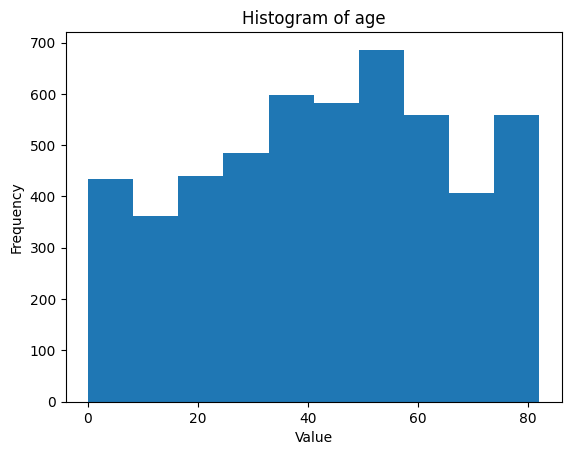

Column: hypertension
Mean: 0.0974559686888454
Standard deviation: 0.29660667423379117
Skewness: 2.7153916581245294
Kurtosis: 5.375455600474597


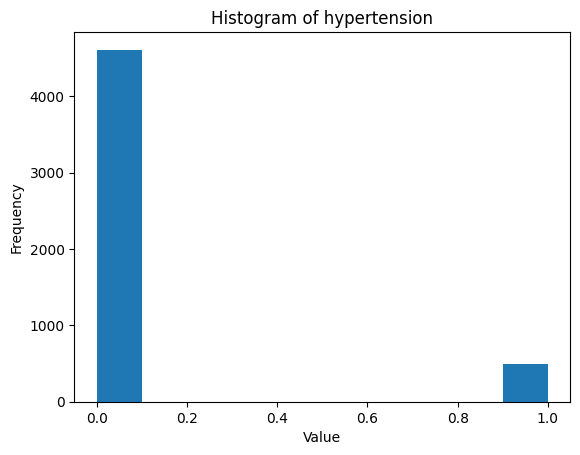

Column: heart_disease
Mean: 0.05401174168297456
Standard deviation: 0.22606298750336543
Skewness: 3.947243966661894
Kurtosis: 13.586052216807259


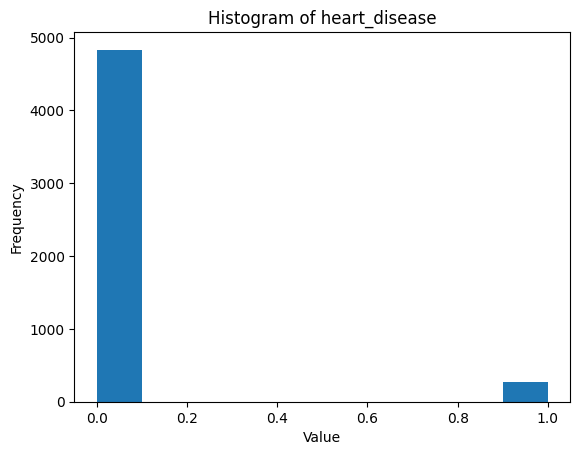

Column: avg_glucose_level
Mean: 106.1476771037182
Standard deviation: 45.28356015058198
Skewness: 1.5722838665030459
Kurtosis: 1.6804785404038278


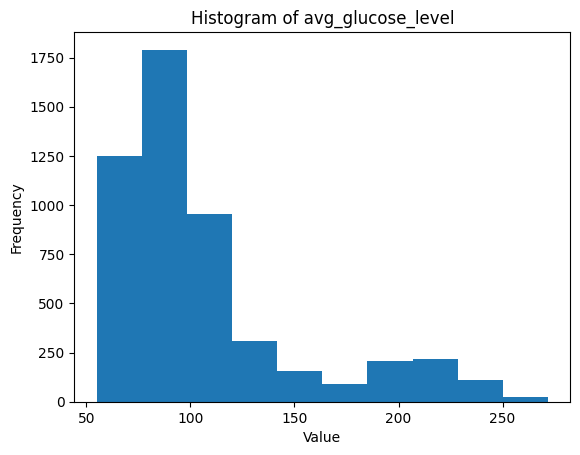

Column: bmi
Mean: 28.893236911794666
Standard deviation: 7.854066729680164
Skewness: 1.0553402052962912
Kurtosis: 3.3626591656236746


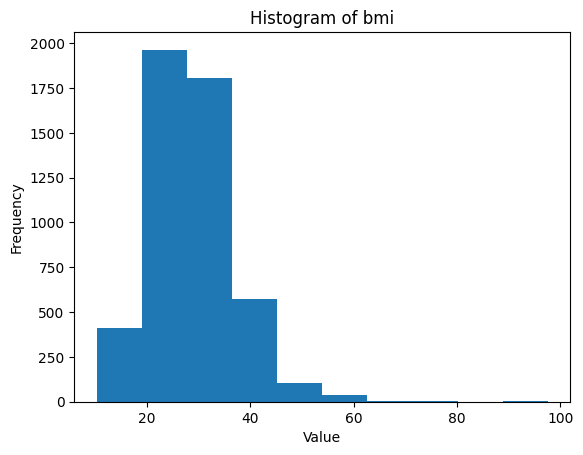

In [ ]:
# Identify the numerical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64','uint8']).columns

# Loop through the numerical columns and find the distribution of each column
for col in numerical_cols:
    # Calculate the mean, standard deviation, skewness, and kurtosis
    mean = data[col].mean()
    std = data[col].std()
    skew = data[col].skew()
    kurt = data[col].kurtosis()

    # Print the results
    print(f"Column: {col}")
    print(f"Mean: {mean}")
    print(f"Standard deviation: {std}")
    print(f"Skewness: {skew}")
    print(f"Kurtosis: {kurt}")

    # Create a histogram
    plt.hist(data[col])
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

We can see that heart attack and hypertension are both boolean types columns, so we change their type to boolean

In [ ]:
df['heart_disease'] = df['heart_disease'].astype(bool)
df['hypertension'] = df['hypertension'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   bool   
 2   heart_disease                   5110 non-null   bool   
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   stroke                          5110 non-null   int64  
 6   ever_married_Yes                5110 non-null   bool   
 7   Residence_type_Urban            5110 non-null   bool   
 8   work_type_Govt_job              5110 non-null   bool   
 9   work_type_Never_worked          5110 non-null   bool   
 10  work_type_Private               5110 non-null   bool   
 11  work_type_Self-employed         5110 non-null   bool   
 12  work_type_children              51

All except three columns are boolean features.
Age, BMI, and glucose levels are numerical features. The first two are normally distributed, and the last one looks like a binomial-logit normal distribution.
We can see that the distributions make sense.


 So we can move on to determining outliers.



To check outliers, we will use the **Isolation forest** model. The model gives a score to each outlier point. We would like to identify how many such extreme points there are in our dataset and, by doing so, see if they have an effect and whether we would like to consider them.
Isolation Forest is an algorithm for data anomaly detection. Isolation Forest detects anomalies using binary trees. In essence, the algorithm relies upon the characteristics of anomalies, i.e., being few and different, in order to detect anomalies.

In [ ]:
from sklearn.ensemble import IsolationForest

# Create an Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.01)
nomerical_df = df[['bmi','avg_glucose_level', 'age']]
# Fit the model to the data
model.fit(nomerical_df)

# Predict the outlier scores for each data point
outlier_scores = model.predict(nomerical_df)

# Identify the data points with the highest outlier scores
outliers = nomerical_df[outlier_scores == -1]

# Print the outliers
print(outliers)




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


            bmi  avg_glucose_level    age
17    48.900000             233.29  52.00
94    56.600000             224.10  45.00
161   45.500000             242.52  70.00
218   54.600000             205.84  74.00
230   60.900000             129.54  57.00
317   64.800000              78.40  52.00
423   60.200000             170.05  61.00
498   71.900000             210.48  42.00
872   78.000000              70.03  23.00
1003  53.400000             206.25  50.00
1012  21.100000             246.34  81.00
1252  54.800000             206.40  55.00
1449  47.500000             253.16  82.00
1477  66.800000              72.63  53.00
1493  48.500000             168.15  18.00
1543  15.700000             242.84  33.00
1557  49.800000              56.63  21.00
1686  51.800000             234.82  59.00
1797  57.700000             187.52  62.00
1961  49.800000             212.97  40.00
1973  17.000000             206.25   4.00
1975  56.100000             231.69  63.00
2019  97.600000              61.67

We see strange things like BMI values larger than 60, which means hyper-obesity. Some of them are more than 70, and by very good chance, they have the wrong values. We will see if removing these values will make our model perform better.

Let's start with the entire dataset first.

# Model

We need to handle our unbalanced dataset. The issue of class imbalance can result in a serious bias towards the majority class, reducing the classification performance and increasing the number of false nagatives. How can we alleviate the issue? The most commonly used techniques is data resampling either under-sampling the majority of the class, or over-sampling the minority class, or a mix of both.

One of the best way to hendle unbalanced data is ADASYN (Adaptive Synthetic Sampling). ADASYN is a technique used to generate synthetic samples for the minority class to balance out the dataset.

In [ ]:
from sklearn.model_selection import train_test_split

# Separate features and target
features = df.drop('stroke', axis=1)
target = df['stroke']
for column in features.columns:
  # Check if the column is of type "bool"
  if df[column].dtype == "bool":
    # Replace True with 1 and False with 0
    features[column] = features[column].replace({True: 1, False: 0})
target = target.replace({True: 1, False: 0})




# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42, stratify=target)

# Print the number of samples in each set
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

Number of training samples: 4088
Number of testing samples: 1022


In [ ]:



# Step 5: Apply ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Print the number of samples in each set
print(f"Number of training samples after resample: {X_train_resampled.shape[0]}")




Number of training samples after resample: 7743


ROC AUC: 0.7370987654320988
Accuracy: 0.6262230919765166
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.61      0.76       972
           1       0.10      0.86      0.18        50

    accuracy                           0.63      1022
   macro avg       0.55      0.74      0.47      1022
weighted avg       0.95      0.63      0.73      1022



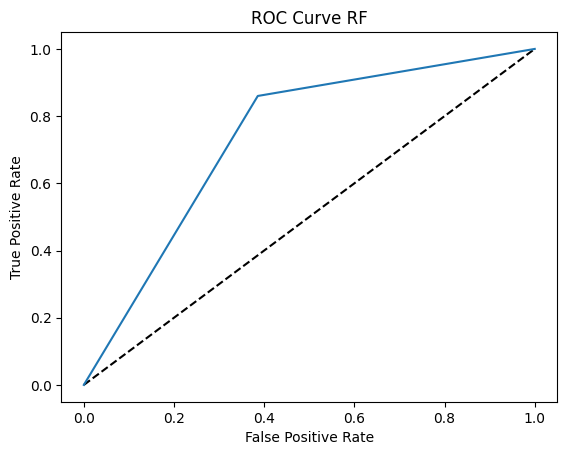

In [ ]:
from sklearn.ensemble import RandomForestClassifier


class_weight = dict({1:10, 0:1})

model = RandomForestClassifier(bootstrap=True,
            class_weight=class_weight,
            criterion='gini',
            max_depth=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100,
            oob_score=False,
            random_state=42,
            verbose=0, warm_start=False)
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
print('ROC AUC:', roc_auc)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)



# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--') # diagonal line
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RF')
plt.show()

Now after we over smapled the data with ADASYN, we train our model.

ROC AUC: 0.7370987654320988
Accuracy: 0.7211350293542075
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.72      0.83       972
           1       0.13      0.80      0.22        50

    accuracy                           0.72      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.72      0.80      1022



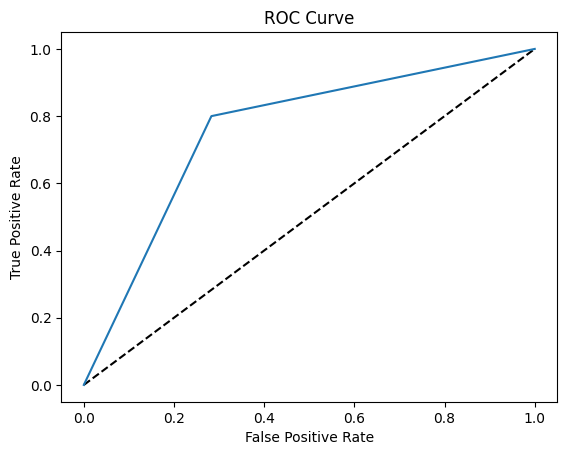

In [ ]:
# Step 6: Model Training
model = SVC(kernel='rbf')  # Example model, you can use any other classifier
model.fit(X_train_resampled, y_train_resampled)

# Step 7: Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
print('ROC AUC:', roc_auc)
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


# Plot the ROC curve
plt.plot([0, 1], [0, 1], 'k--') # diagonal line
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.show()

We can see that Random Forest and SVM gave different results.

The precision for both models was great for predicting nonstroke data - 0.99.
So, 99% of the patients that the models predicted were nonstroke.
However, regarding the recall, the random forest model falls short with a rate of 0.61, compared to the SVM model's 0.72. This means that only 61% of the nonstroke cases were correctly identified by the random forest model, while the SVM model managed to identify 72%.
In the stroke patients, we received a 0.1 precision in the random forest model and 0.13 in the SVM model. So, the SVM did slightly better in accuracy. predicting The patients with strokes. On the other hand, the recall in this case is better in the random forest model - 0.86 compared to 0.8.

So, how should we choose the best model? We can see that no model did a better job than the other. Each model is better in different matrics.
Two things can help us choose:
1. The weighted F1 score that combines both metrics for both cases. In this case, the SVM model performed better - 0.8 compared to 0.73.
2. How big is the data? The SVM model is more complex to run with a large dataset compared to the random forest, which is lighter and can be run in multiple Cores or even a GPU because each tree is trained separately. The dataset is small, so that is not an issue.

**The SVM model won this battle.**




# Summary

In this work, we took a stroke dataset from Kaggle and tried to make a model that could predict if a person will have a stroke from features like marriage, BMI,  age, etc.
After cleaning the data, we encountered missing values in the BMI column. Recognizing that the data followed a normal distribution, we opted for a linear regression model to impute these missing values. This technique, specifically designed for such scenarios, proved an effective tool in our data analysis process. Algorithm for this task. We saw that only a few points received a big anomaly score means that the anomaly points in our data won't influence our results.
We investigated our data and found that it needs to be more balanced. The stroke data is less than 5% of the data, and we attacked this problem with the ADASYN algorithm by updating our dataset with synthetic data points of the column we want to balance.
The last part involved training two models: a Random forest classifier with class weights and an SVM model with an Rbf filter.
We discussed the results and decided that the SVM model gives the best results.





I want to use and ensemble model that uses Random Forest and Support Vector Machine regressor with RBF kernel - two of the best models for reggration problems.

In [ ]:
# Create a Random Forest regressor
rf = RandomForestRegressor()

# Create a Support Vector Machine regressor with RBF kernel
svm = SVR(kernel='rbf')


# Define the hyperparameter grids for each model
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

svm_param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Create the GridSearchCV objects for each model
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5)
svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5)

# Fit the GridSearchCV objects to the training data
rf_grid_search.fit(X_train, y_train)
svm_grid_search.fit(X_train, y_train)

# Get the best hyperparameters for each model
best_rf_params = rf_grid_search.best_params_
best_svm_params = svm_grid_search.best_params_

# Create new models with the best hyperparameters
rf_best = RandomForestRegressor(**best_rf_params)
svm_best = SVR(**best_svm_params)

# Combine the two models using a voting ensemble
ensemble = VotingRegressor(estimators=[('rf', rf_best), ('svm', svm_best)])

# Fit the ensemble model to the training data
ensemble.fit(X_train, y_train)

# Evaluate the ensemble model on the test data
ensemble_score = ensemble.score(X_test, y_test)

# Print the ensemble score
print(f"Ensemble score: {ensemble_score}")

Ensemble score: 0.0588260094060149


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



# Create a Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new model with the best hyperparameters
rf_best = RandomForestClassifier(**best_params)

# Fit the new model to the training data
rf_best.fit(X_train, y_train)

# Evaluate the new model on the test data
rf_best_score = rf_best.score(X_test, y_test)

# Print the new model score
print(f"Random Forest (best) score: {rf_best_score}")

Random Forest (best) score: 0.9510763209393346


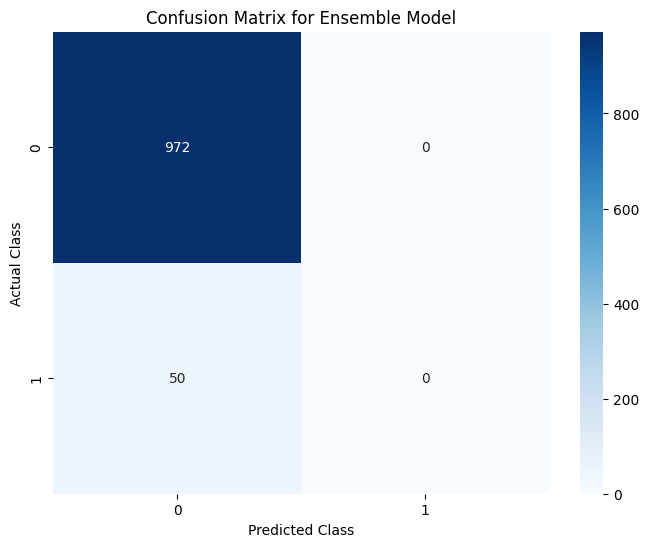

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the classes for the test data using the ensemble model
y_pred = rf_best.predict(X_test)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix for Ensemble Model")
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the F1 score
print(f"F1 score: {f1}")

F1 score: 0.0
